<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

# 실습 내용

- Titanic 데이터로 모델링합니다.
- KNN 알고리즘으로 모델링합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [69]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [70]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/titanic.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [71]:
# 상위 몇 개 행 확인
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
# 기초통계량 확인
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [73]:
# Survived 범주값 개수 확인
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [74]:
# NaN 값 확인
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [75]:
# 상관관계 확인
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


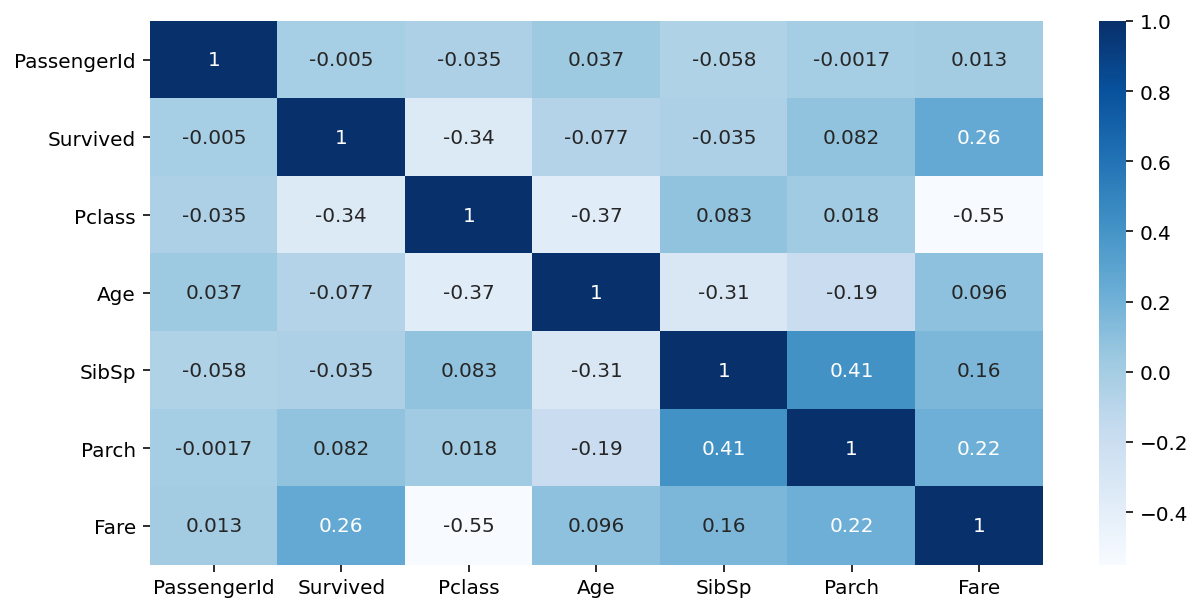

In [76]:
# 상관관계 시각화
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.show()

# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) Title 변수 추가**

In [77]:
# 호칭 추출
data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [78]:
# 대표 호칭 이외는 Others로 변경
main_tit_list = ['Mr', 'Miss', 'Mrs']
data.loc[data['Title'].isin(main_tit_list)==False, ['Title']] = 'Others'

**2) 결측치 처리**

In [79]:
# Age 결측치를 Title 별 중앙값으로 채우기
data['Age'].fillna(data.groupby('Title')['Age'].transform('median'), inplace=True)

In [80]:
# Embarked 최빈값으로 채우기
data['Embarked'].fillna('S', inplace=True)

**3) AgeGroup 변수 추가**

In [81]:
# 변수 추가
data['AgeGroup'] = pd.cut(data['Age'], 
                          bins=[0, 16, 25, 35, 60, 100], 
                          labels=['0_16', '17_25', '26_35', '36_60', '61_100'])

**4) 가변수화**

In [82]:
# 가변수화
dummy_vars = ['Title', 'AgeGroup', 'Pclass', 'Sex', 'Embarked']
data = pd.get_dummies(data, columns=dummy_vars, drop_first=True)

**5) 불필요한 변수 제거**

In [83]:
# 불필요한 열 제거
drop_cols = ['PassengerId', 'Name', 'Age', 'Ticket', 'Cabin']
data.drop(drop_cols, axis=1, inplace=True)

# 확인
data.head()

,Survived,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Others,AgeGroup_17_25,AgeGroup_26_35,AgeGroup_36_60,AgeGroup_61_100,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,1,0,7.2500,1,0,0,1,0,0,0,0,1,1,0,1
1,1,1,0,71.2833,0,1,0,0,0,1,0,0,0,0,0,0
2,1,0,0,7.9250,0,0,0,0,1,0,0,0,1,0,0,1
3,1,1,0,53.1000,0,1,0,0,1,0,0,0,0,0,0,1
4,0,0,0,8.0500,1,0,0,0,1,0,0,0,1,1,0,1


**6) x, y 분리**

In [84]:
# target 확인
target = 'Survived'

# 데이터 분리
x = data.drop(target, axis=1)
y = data[target]

**7) 정규화**

In [85]:
# 정규화
cols = ['SibSp', 'Parch', 'Fare']
x[cols] = (x[cols] - x[cols].min()) / (x[cols].max() - x[cols].min())

# 확인
x.head()

,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Others,AgeGroup_17_25,AgeGroup_26_35,AgeGroup_36_60,AgeGroup_61_100,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.125,0.0,0.014151,1,0,0,1,0,0,0,0,1,1,0,1
1,0.125,0.0,0.139136,0,1,0,0,0,1,0,0,0,0,0,0
2,0.000,0.0,0.015469,0,0,0,0,1,0,0,0,1,0,0,1
3,0.125,0.0,0.103644,0,1,0,0,1,0,0,0,0,0,0,1
4,0.000,0.0,0.015713,1,0,0,0,1,0,0,0,1,1,0,1


**8) 학습용, 평가용 데이터 분리**

In [86]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                   random_state=2022)

# 4.모델링

- 본격적으로 모델을 **선언**하고 **학습**하고 **평가**하는 과정을 진행합니다.

In [87]:
# 1단계: 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [88]:
# 2단계: 선언하기
model = KNeighborsClassifier(n_neighbors=5) # n_neighbors=5 : 디폴트 값

In [89]:
# 3단계: 학습하기
model.fit(x_train, y_train)

KNeighborsClassifier()

In [90]:
# 4단계: 예측하기
y_pred = model.predict(x_test)

In [91]:
# 5단계: 평가하기
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[153  15]
 [ 34  66]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       168
           1       0.81      0.66      0.73       100

    accuracy                           0.82       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268



In [92]:
# 성능 정보 수집
from sklearn.metrics import accuracy_score

result = {}
my_k = 0
max_score = 0
for k in range(1, 61, 1) :
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result[k] = accuracy_score(y_test, y_pred)
    if max_score < result[k] :
        max_score = result[k]
        my_k = k
print(my_k, max_score)

11 0.8208955223880597


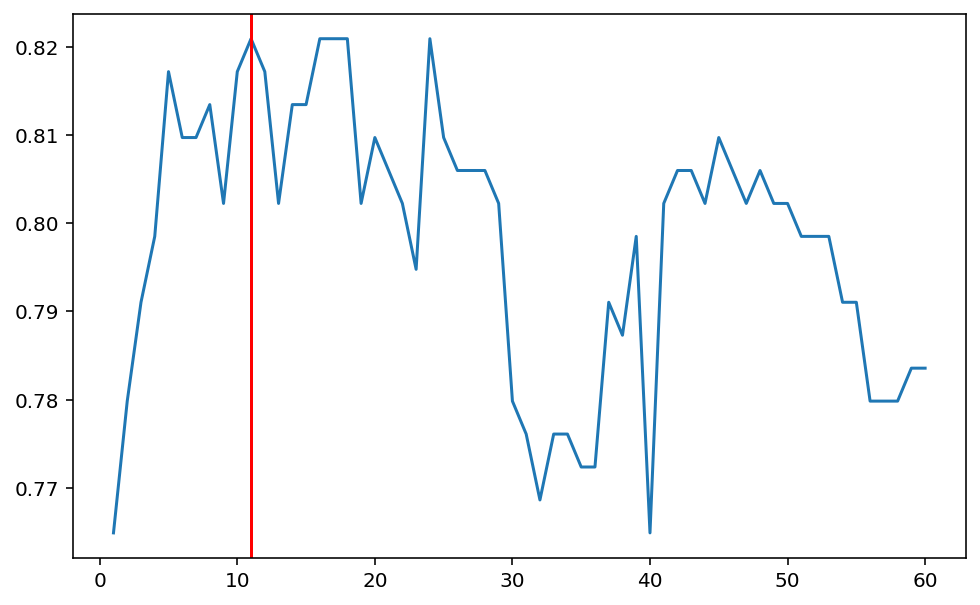

In [93]:
# 성능 분석 - 시각화
plt.figure(figsize=(8, 5))
plt.plot(result.keys(), result.values())
plt.axvline(my_k, color='r')
plt.show()